# 1 - Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from jax import jit, grad
import qcsys as qs
import jax.numpy as jnp


In [3]:
Ec_q = 0.8440030577770504/1.5
El_q = 0.29995365063860974
Ej_q = 3.7549273414716677*1.5

qubit = qs.Fluxonium.create(
    25,
    {"Ec": Ec_q, "El": El_q, "Ej": Ej_q, "phi_ext": 0.5},
    use_linear=False,
    N_pre_diag=100,
)

Text(0.5, 1.0, '$\\theta_{\\rm ext} = 0.5\\Phi_0$')

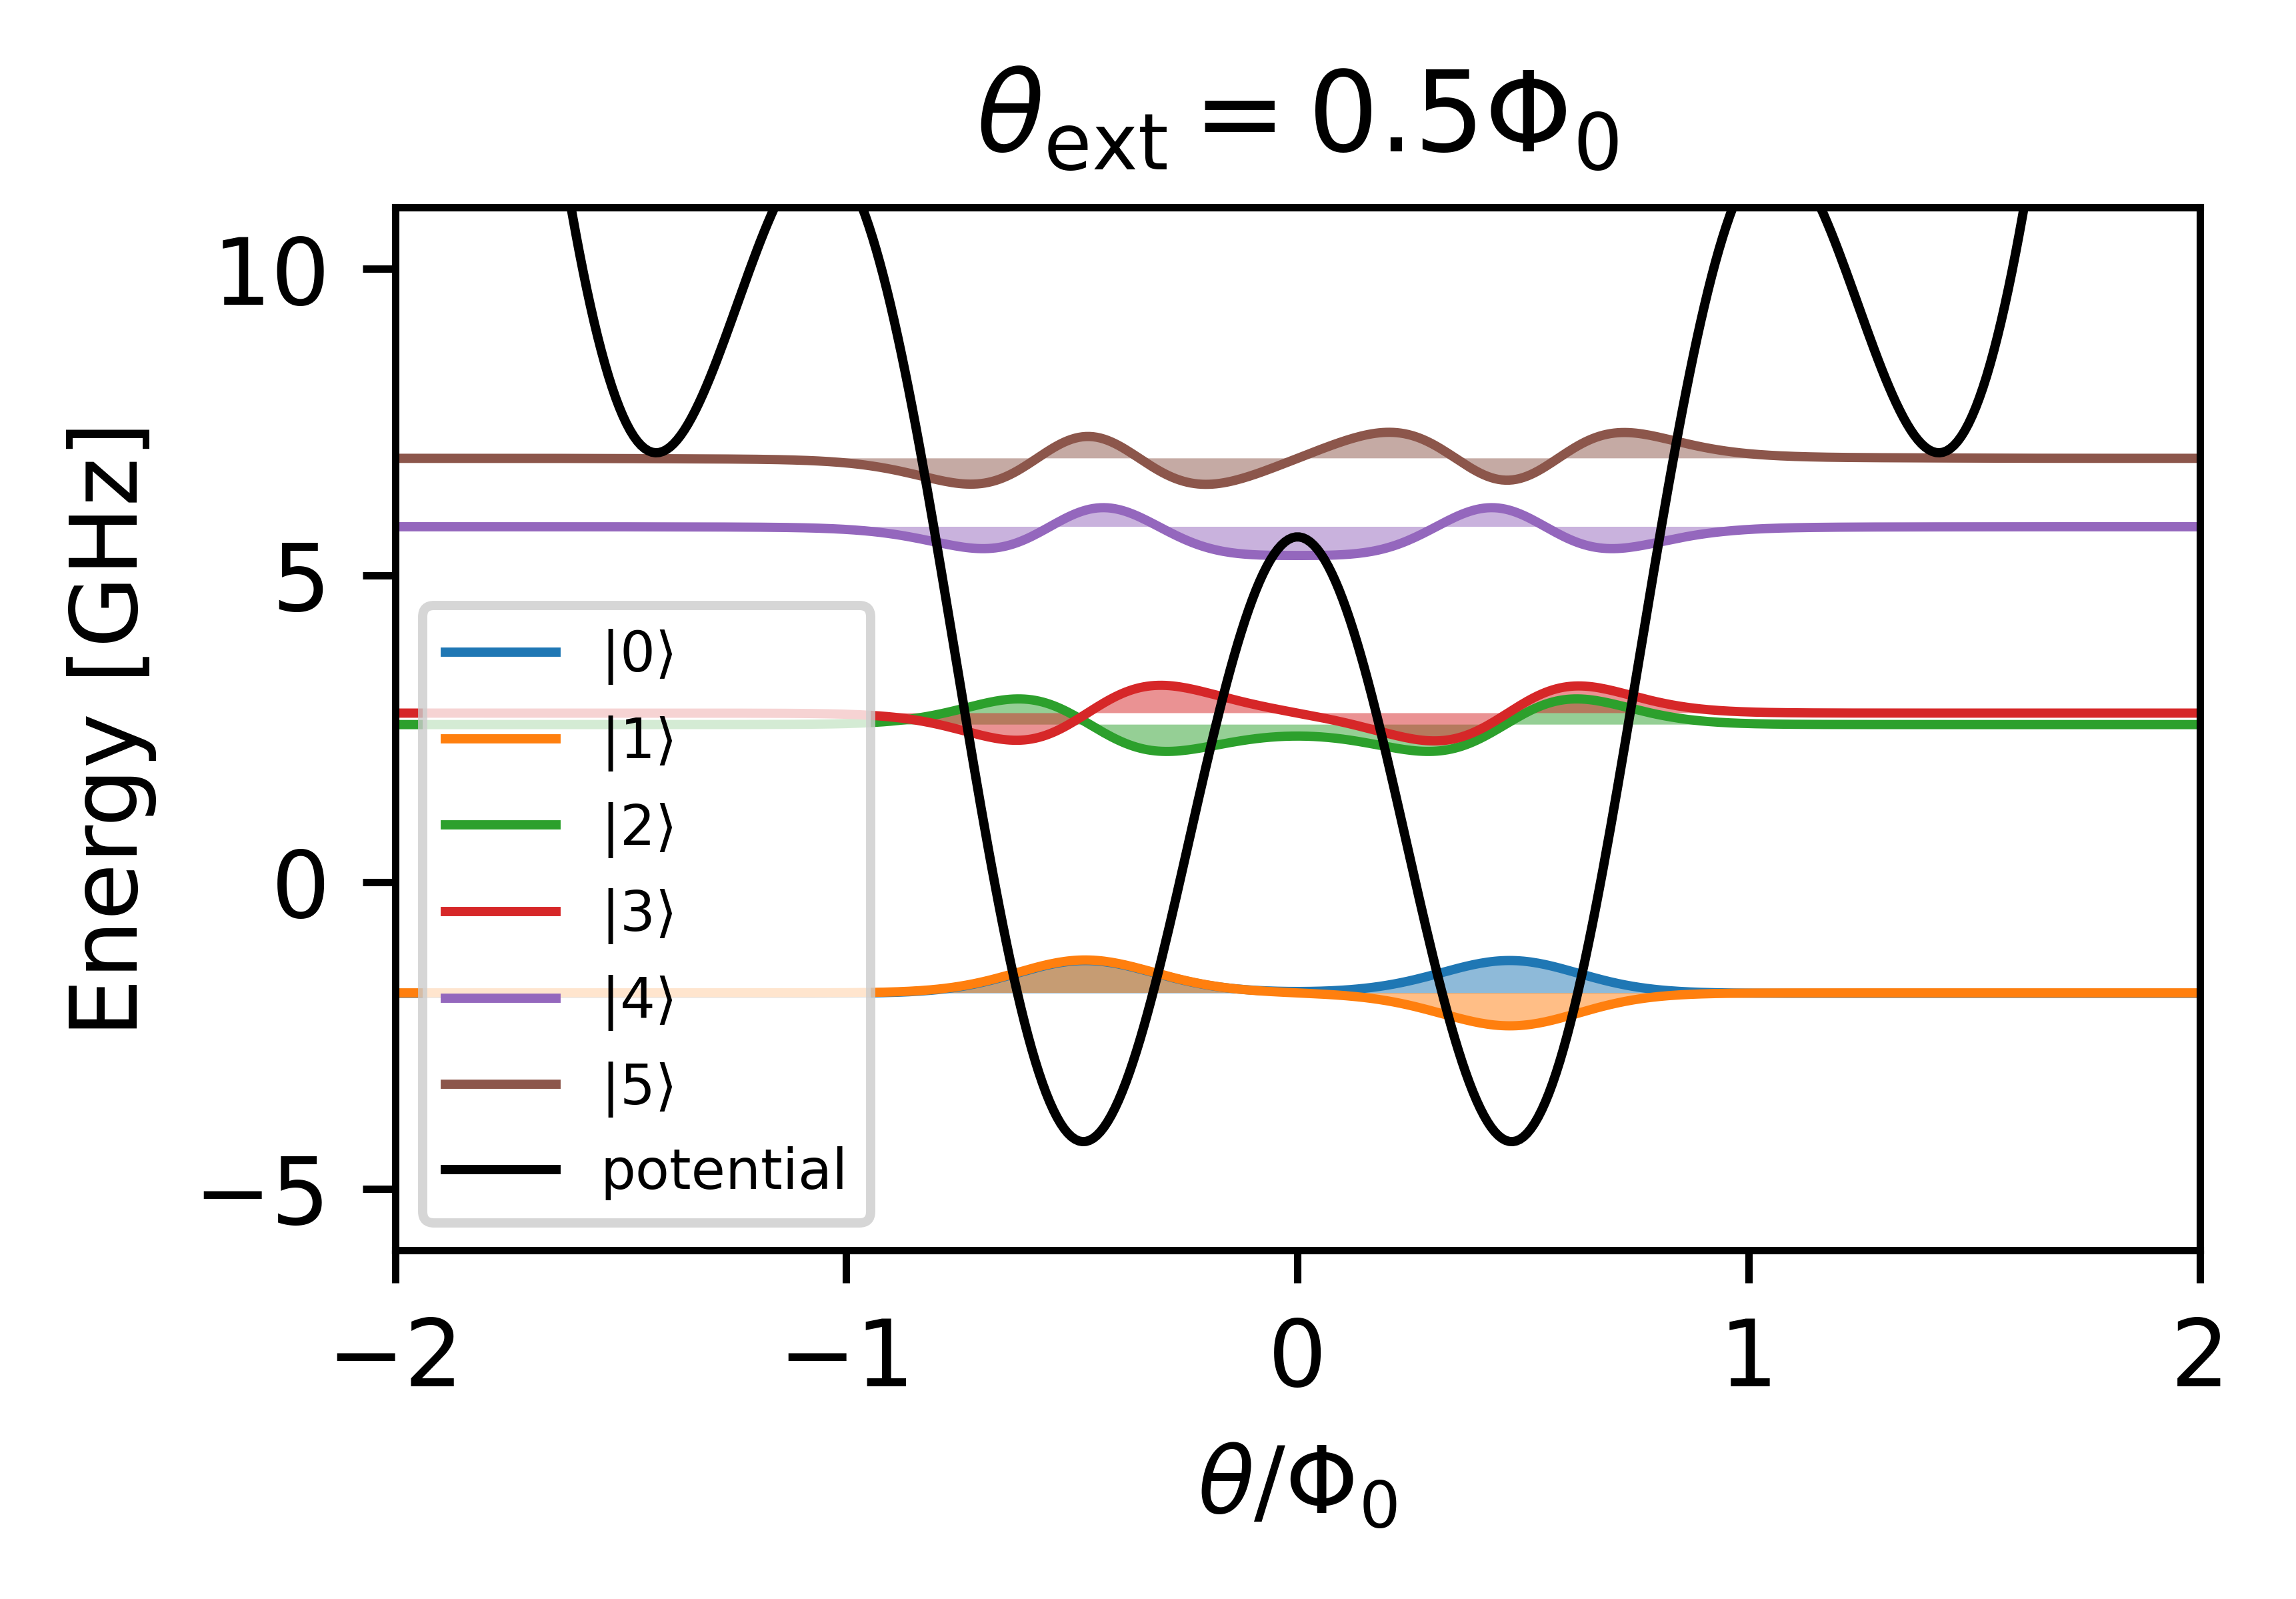

In [4]:
phi_vals = jnp.linspace(-2,2,500)
axs = qubit.plot_wavefunctions(phi_vals, max_n=6, mode="real")
axs.set_ylim(-6,11)
axs.set_xlim(-2,2)
axs.set_xlabel("$\\theta/\\Phi_0$")
axs.set_title("$\\theta_{\\rm ext} = 0.5\\Phi_0$")

# 2 - Devices

In [5]:
_, Ec_a, El_a = qs.calculate_lambda_over_four_resonator_zpf(3, 50)

resonator = qs.Resonator.create(
    10,
    {"Ec": Ec_a, "El": El_a},
    N_pre_diag=10,
)

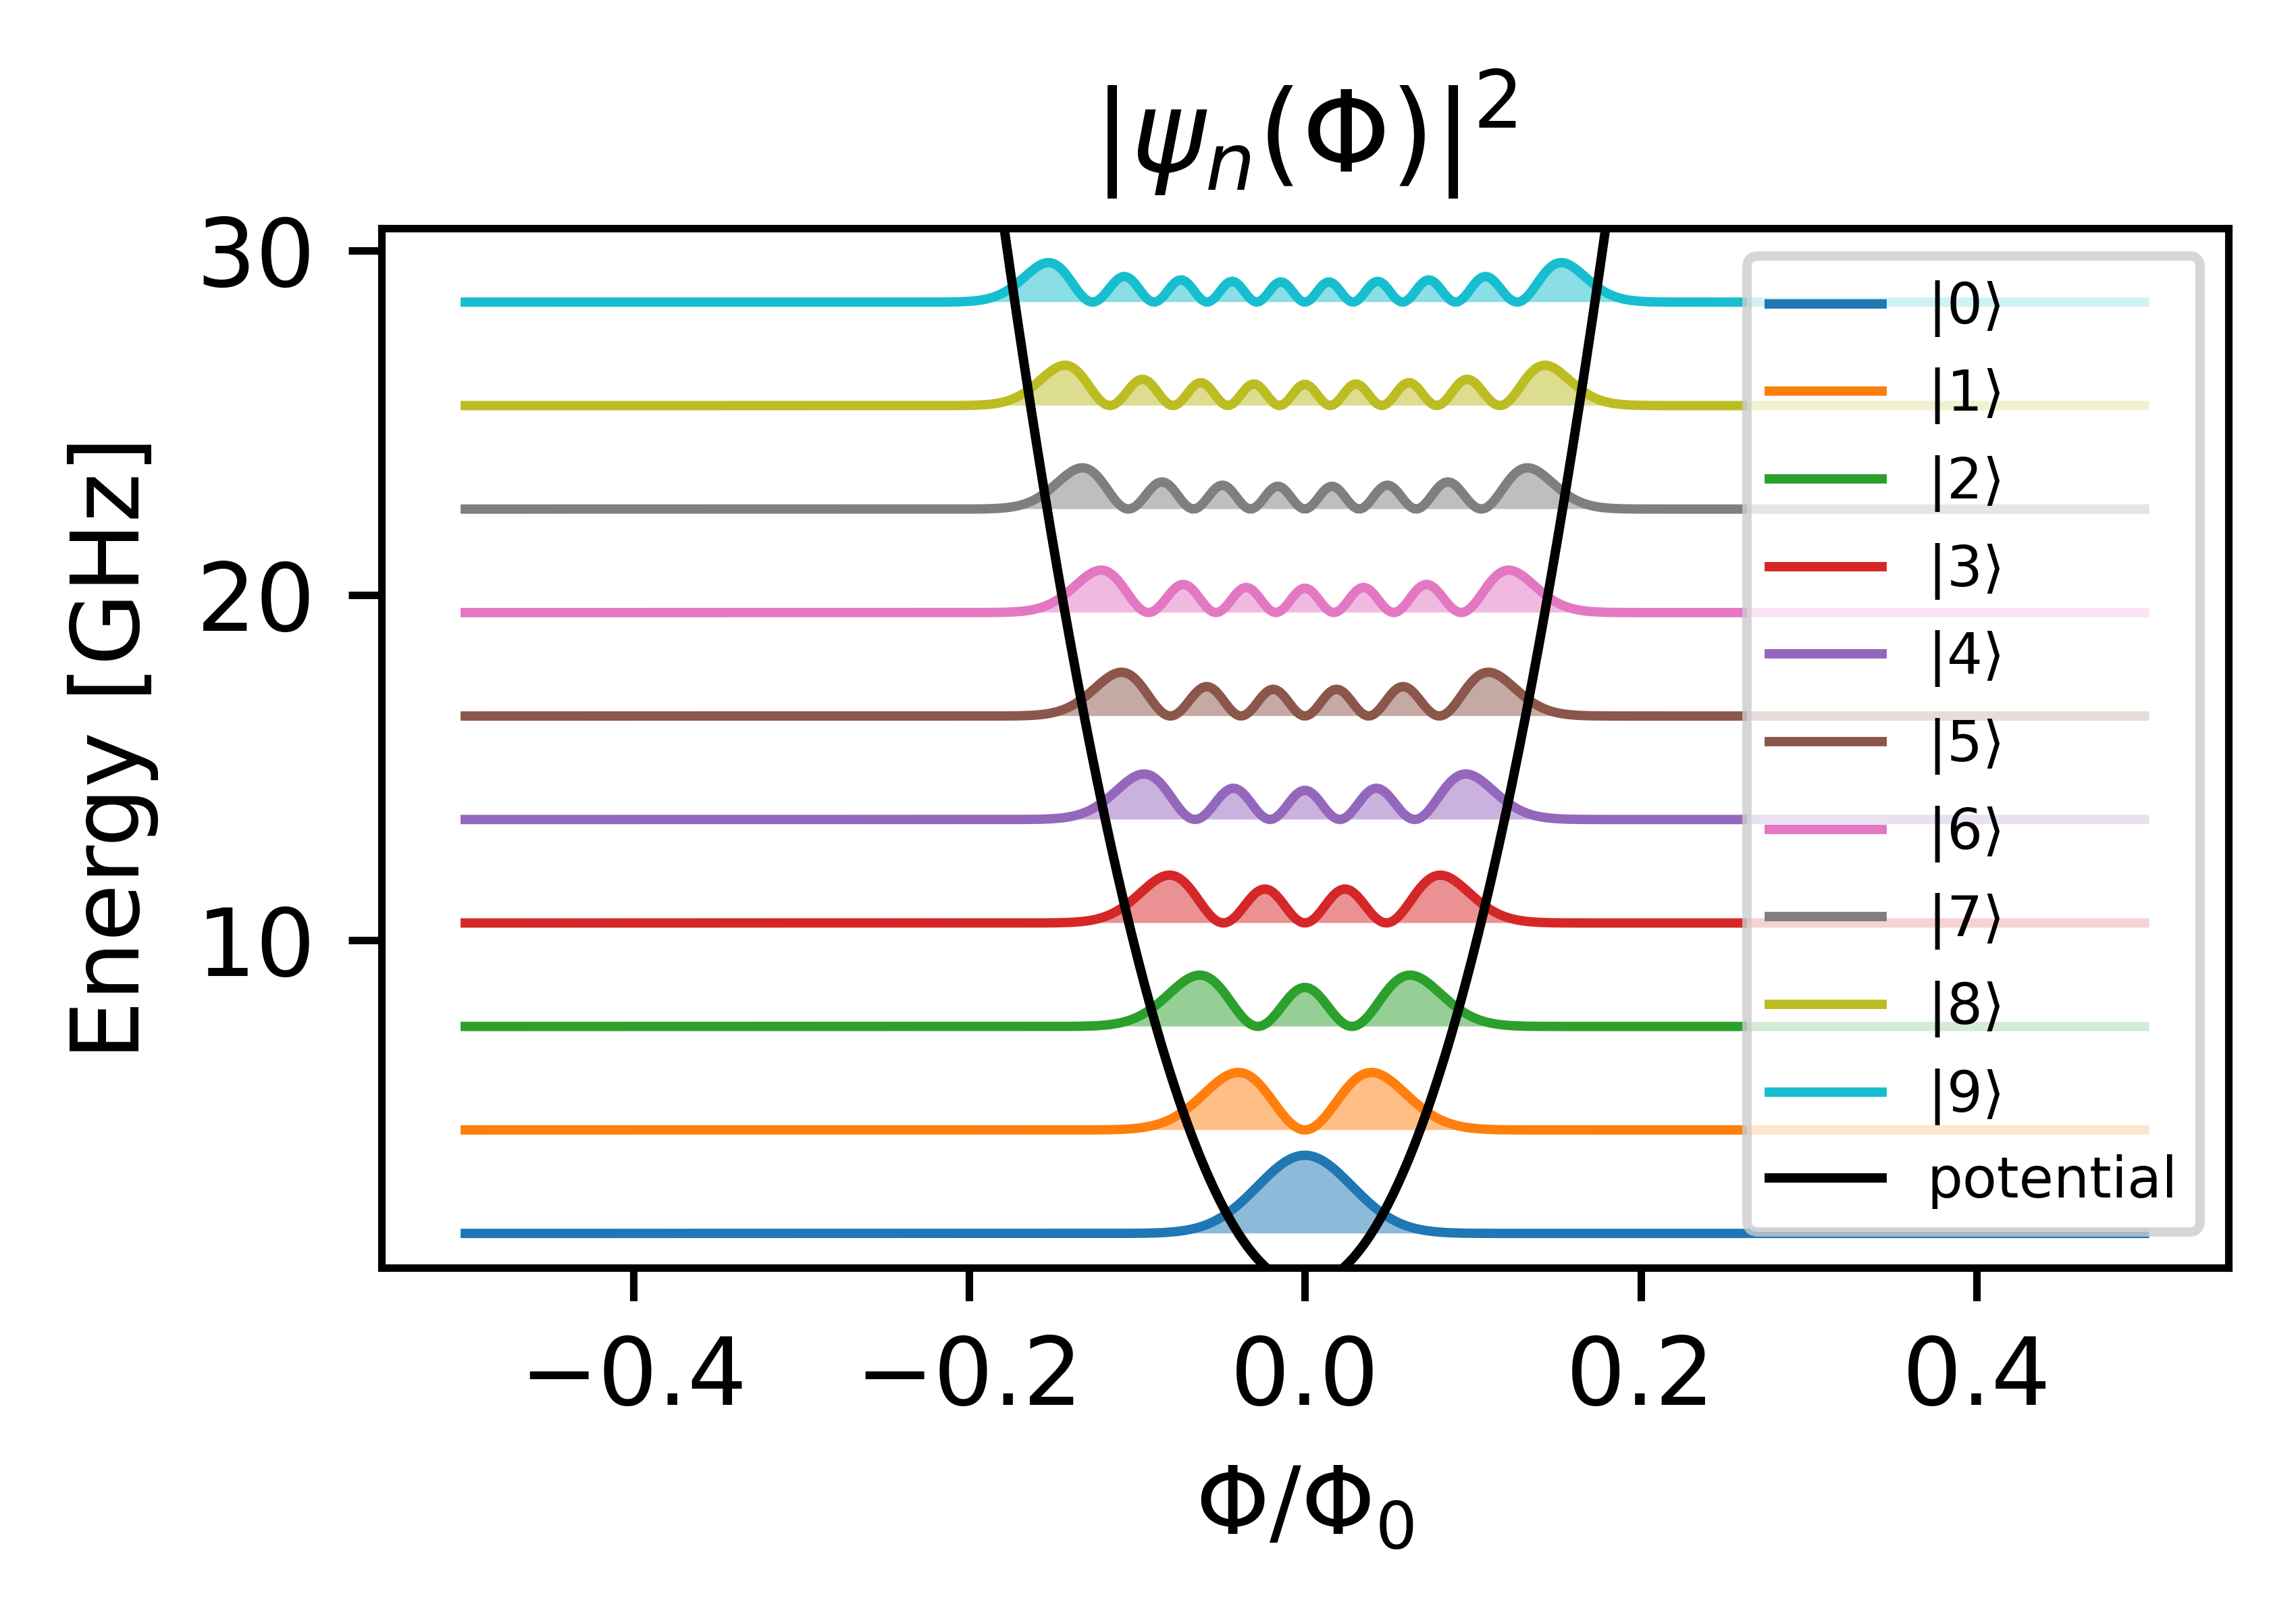

In [6]:
phi_vals = jnp.linspace(-0.5,0.5,500)
axs = resonator.plot_wavefunctions(phi_vals)

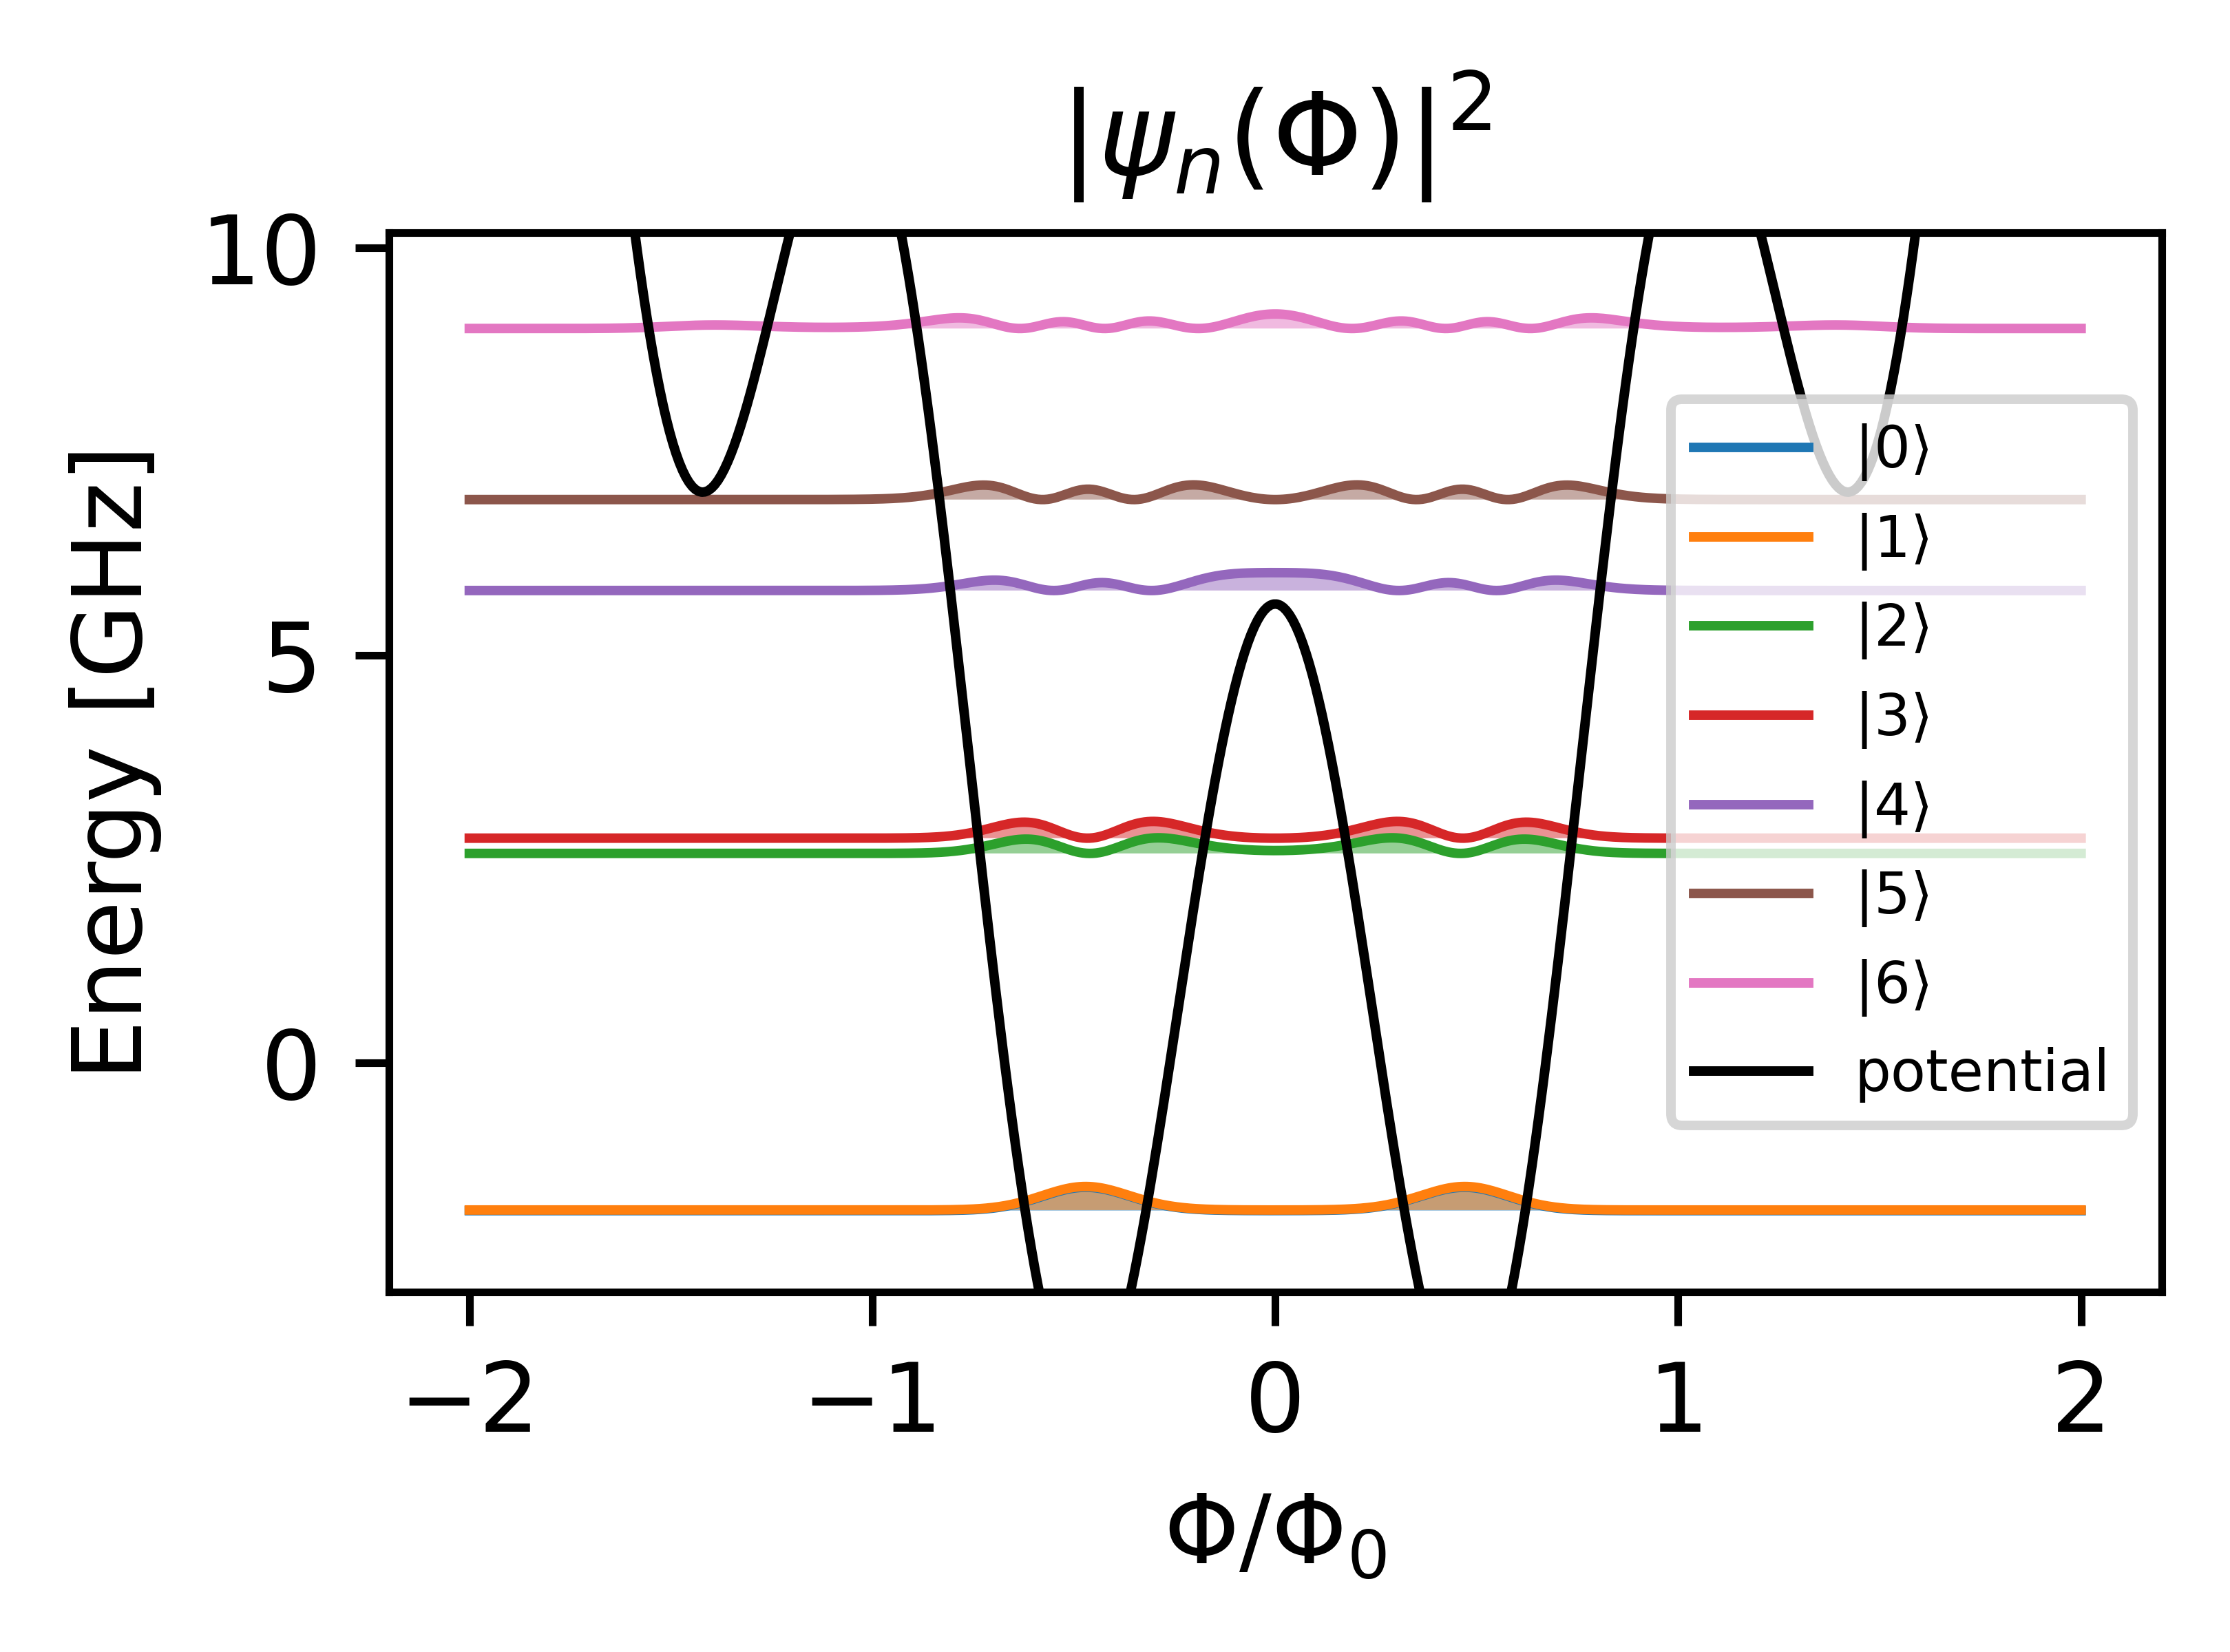

In [14]:
phi_vals = jnp.linspace(-2,2,500)
axs = qubit.plot_wavefunctions(phi_vals, max_n=7)

# 3 - System

In [8]:
g_rq = 0.3

devices = [resonator, qubit]
r_indx = 0
q_indx = 1
Ns = [device.N for device in devices]

a0 = qs.promote(resonator.ops["a"], r_indx, Ns)
a0_dag = qs.promote(resonator.ops["a_dag"], r_indx, Ns)

q0 = qs.promote(qubit.ops["a"], q_indx, Ns)
q0_dag = qs.promote(qubit.ops["a_dag"], q_indx, Ns)

couplings = []
couplings.append(-g_rq * (a0 - a0_dag) @ (q0 - q0_dag))

system = qs.System.create(devices, couplings=couplings)
system.params["g_rq"] = g_rq

In [9]:
Es, kets = system.calculate_eig()

# chi ----
χ_e = Es[1:, 1] - Es[:-1, 1]
χ_g = Es[1:, 0] - Es[:-1, 0]
χ = χ_e - χ_g

# kerr ----
# kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
# kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

χ, K_g, K_e

(Array([-1.90191547e-02,  1.07561225e-02,  2.91160708e-03,  4.80531085e-03,
         1.06130050e-03,  1.57428501e-02,  1.55108802e+00, -2.14832765e+00,
        -9.68003648e-02], dtype=float64),
 Array([-0.01783517, -0.01951432,  0.0232689 , -0.00763039,  0.01485071,
         0.0411102 ,  2.37994545, -1.97642837], dtype=float64),
 Array([ 0.01194011, -0.02735883,  0.0251626 , -0.0113744 ,  0.02953226,
         1.57645537, -1.31947022,  0.07509891], dtype=float64))

In [10]:
Es, kets = system.calculate_eig()

# chi ----
χ_e = Es[1:, 1] - Es[:-1, 1]
χ_g = Es[1:, 0] - Es[:-1, 0]
χ = χ_e - χ_g

# kerr ----
# kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
# kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

χ, K_g, K_e

(Array([-1.90191547e-02,  1.07561225e-02,  2.91160708e-03,  4.80531085e-03,
         1.06130050e-03,  1.57428501e-02,  1.55108802e+00, -2.14832765e+00,
        -9.68003648e-02], dtype=float64),
 Array([-0.01783517, -0.01951432,  0.0232689 , -0.00763039,  0.01485071,
         0.0411102 ,  2.37994545, -1.97642837], dtype=float64),
 Array([ 0.01194011, -0.02735883,  0.0251626 , -0.0113744 ,  0.02953226,
         1.57645537, -1.31947022,  0.07509891], dtype=float64))

# 4 - auto differentiation

In [11]:
@jit
def calculate_metrics(f_r):
    # devices ---

    # Resonator
    _, Ec_a, El_a = qs.calculate_lambda_over_four_resonator_zpf(f_r, 50)

    resonator = qs.Resonator.create(
        10,
        {"Ec": Ec_a, "El": El_a},
        N_pre_diag=10,
    )

    # Fluxonium
    Ec_q = 1
    El_q = 0.5
    Ej_q = 8

    qubit = qs.Fluxonium.create(
        25,
        {"Ec": Ec_q, "El": El_q, "Ej": Ej_q, "phi_ext": 0.47},
        use_linear=False,
        N_pre_diag=100,
    )

    # system ----
    g_rq = 0.3

    devices = [resonator, qubit]
    r_indx = 0
    q_indx = 1
    Ns = [device.N for device in devices]

    a0 = qs.promote(resonator.ops["a"], r_indx, Ns)
    a0_dag = qs.promote(resonator.ops["a_dag"], r_indx, Ns)

    q0 = qs.promote(qubit.ops["a"], q_indx, Ns)
    q0_dag = qs.promote(qubit.ops["a_dag"], q_indx, Ns)

    couplings = []
    couplings.append(-g_rq * (a0 - a0_dag) @ (q0 - q0_dag))

    system = qs.System.create(devices, couplings=couplings)
    system.params["g_rq"] = g_rq

    # metrics ----
    Es, kets = system.calculate_eig()

    # chi
    χ_e = Es[1:, 1] - Es[:-1, 1]
    χ_g = Es[1:, 0] - Es[:-1, 0]
    χ = χ_e - χ_g

    # kerr
    # kerr[0,n] = (E(n+2, g) - E(n+1, g)) - (E(n+1, g) - E(n, g))
    # kerr[1,n] = (E(n+2, e) - E(n+1, e)) - (E(n+1, e) - E(n, e))
    K_g = (Es[2:, 0] - Es[1:-1, 0]) - (Es[1:-1, 0] - Es[0:-2, 0])
    K_e = (Es[2:, 1] - Es[1:-1, 1]) - (Es[1:-1, 1] - Es[0:-2, 1])

    χ, K_g, K_e

    K_avg = (K_g + K_e)/2

    return jnp.abs(χ[0]/K_avg[0])

grad_calculate_metrics = jit(grad(calculate_metrics))

In [12]:
calculate_metrics(3.0)

Array(1.64684707, dtype=float64)

In [13]:
grad_calculate_metrics(4.0)

Array(5.23220617, dtype=float64, weak_type=True)